# K-Means w/ PCA on Pneumonia X-Rays

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time

In [2]:
from sklearn.preprocessing import normalize

In [3]:
#Helper function to get cluster_plot
def get_cluster_plot(rows, Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(256,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

## Setup: Reading and formatting images

The data used in this notebook consist of lung x-rays from healthy individuals and individuals infected with pneumonia. Although the data comes with the identifying labels, we will remove them in order to create an unlabeled dataset. Images will also be resized to 256x256.

In [4]:
#Function to process .jpeg images into array for KMeans
def process_imgKMeans():
    print("Reading images for KMeans")
    array = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    return array

In [5]:
#Function to process .jpeg images into array for PCA
def process_imgPCA():
    print("Reading images for PCA")
    array = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)
    
    return array

In [6]:
#processing images
x_raysKMeans = process_imgKMeans()
x_raysPCA = process_imgPCA()

Reading images for KMeans
Reading images for PCA


In [7]:
#convert to arrays
x_raysKMeans, x_raysPCA = np.array(x_raysKMeans), np.array(x_raysPCA)

## Visualizing the data:

We can plot images of healthy lungs and infected lungs to visualize the difference between both.

<ipython-input-8-fcb80072e64d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


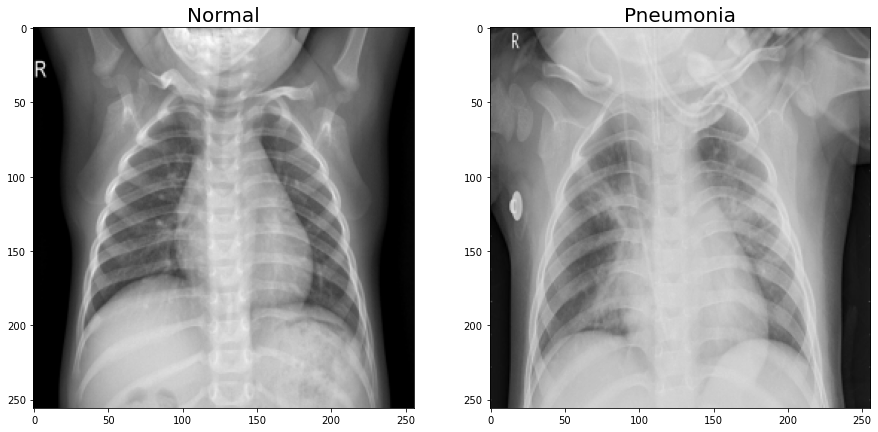

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,9))
axs[0].set_title("Normal", fontsize="20")
axs[0].imshow(x_raysKMeans[2].reshape(256,256), cmap=plt.get_cmap('gray'))
axs[1].set_title("Pneumonia", fontsize="20")
axs[1].imshow(x_raysKMeans[-2].reshape(256,256), cmap=plt.get_cmap('gray'))

fig.show()

From the images above, we can clearly see that lungs with pneumonia look more cloudy than healthy lungs. When observing the images, the cloudiness of the lungs are a common difference between normal and infected lungs.

In [9]:
#shuffle
np.random.shuffle(x_raysKMeans)
np.random.shuffle(x_raysPCA)

In [10]:
#Reshape array to 1D nparray
x_raysKMeans = x_raysKMeans.reshape(5216, -1)/255

In [11]:
#Reshape array to 1D nparray and take transpose to create column vectors
x_raysPCA = x_raysPCA.reshape(5216, -1)/255
x_raysPCA = x_raysPCA.T

## K-means:

Using K-means, we can attempt to find some underlying patterns for our images by assigning our images to certain clusters. We know that the dataset contains x-rays of both healthy and infected lungs and from the visualization, we can clearly see a difference in cloudiness. So we can train our model to try and identify this difference.

In [12]:
#Helper functions for KMeans
def calcSqDistances(X, Kmus):
    res = np.zeros((X.shape[0], Kmus.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Kmus.shape[0]):
            res[i, j] = np.linalg.norm(X[i] - Kmus[j])
    return res

def determineRnk(sqDmat):
    Rnk = np.tile(0, (sqDmat.shape[0], sqDmat.shape[1]))
    for i in range(sqDmat.shape[0]):
        index = np.argmin(sqDmat[i])
        Rnk[i][index] = 1
    
    return Rnk

def recalcMus(X, Rnk):
    recalc = np.zeros((Rnk.shape[1], X.shape[1]))
    
    for i in range(Rnk.shape[1]):
        recalc[i,:] = np.sum((np.array([Rnk[:,i]]).T) * X, axis = 0)/(np.sum(Rnk[:,i], axis = 0))
    return recalc

In [13]:
def runKMeans(matrix, K):
    #load data file specified by fileString from Bishop book
    start = time.time()
    X = matrix

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
#         plotCurrent(X, Rnk, Kmus)
#         time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        diff = np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1))))
        print(diff)
        if diff < 1e-6:
            print(iter)
            break

    # plotCurrent(X, Rnk, Kmus)
    end = time.time()
    print("Total time: {}".format(end - start))
    return Kmus, Rnk

Running K-means for 2 clusters

In [14]:
xray_kmeans, kmeans_rnk = runKMeans(x_raysKMeans, 2)

9154.373771694754
1213.322284011201
715.7681715273027
496.23305736630084
346.54097601869273
255.4319994331667
176.24509009459024
109.6061893123993
69.78794225128998
41.086957268079345
29.463838296749568
28.364583684563428
29.19312341996831
21.00727057447058
16.065880737134325
19.16149515037726
8.115370011189173
6.30284631291927
6.144175072234243
0.0
19
Total time: 62.96466112136841


## Results from K-means:

We can try to cluster K-means with 2 clusters (normal and pneumonia).

In [15]:
print(xray_kmeans)

[[0.21677999 0.22662194 0.24557264 ... 0.07848309 0.07943078 0.08672934]
 [0.16432235 0.16936925 0.1895628  ... 0.06146962 0.06321931 0.07046931]]


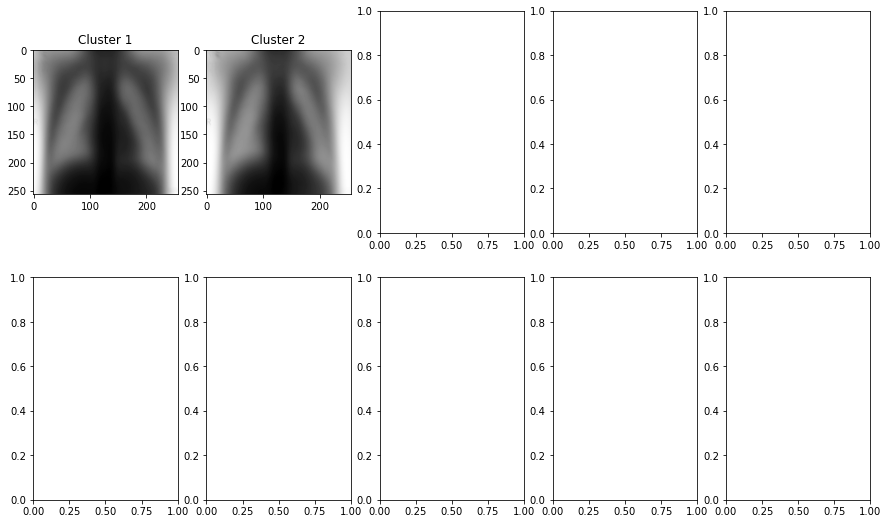

In [16]:
get_cluster_plot(2, xray_kmeans)

<ipython-input-17-ff274d211ad2>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


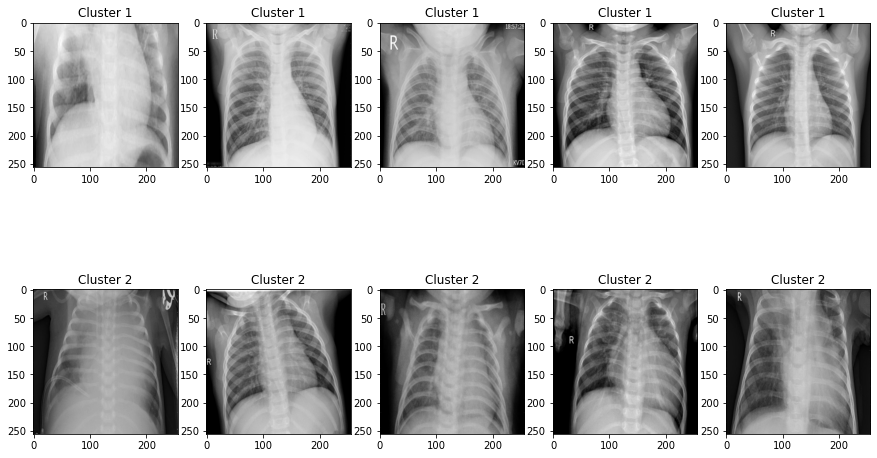

In [17]:
def get_indices(rnk, num_indices):
    
    indices = []
    clusters = rnk.shape[1]
    for i in range(clusters):
      indices.append([])

    i = 0
    j = 0
    while i < num_indices*clusters:
        val = max(rnk[j])
        pos = np.where(rnk[j] == val)[0][0]
        if (len(indices[pos]) != 5):
            indices[pos].append(j)
            i += 1

        j += 1
        
    return indices

indices = get_indices(kmeans_rnk, 5)

def view_images(indices):
    clusters = len(indices)
    num_images = len(indices[0])
    fig, axs = plt.subplots(clusters, num_images, figsize=(15,9))
    for col in range(num_images):
        for i in range(clusters):
            axs[i][col].set_title(f"Cluster {i+1}", fontsize="12")
            axs[i][col].imshow(x_raysKMeans[indices[i][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
    fig.show()
    
view_images(indices)

4 clusters.

In [18]:
four_clusters, kmeans_rnk = runKMeans(x_raysKMeans, 4)

18949.821127879437
3226.139741881901
2009.6995597767818
1399.8295059508123
1114.923116530257
868.7401784545668
704.5194417929893
575.1958811745457
406.3492878251676
405.02389116373683
297.7717685675098
277.046346535993
268.3688860270747
237.2287796067223
211.07020776199374
220.5304139326317
141.41374504167186
125.69790291583243
119.98435422452118
90.37369088784703
69.78019733370155
69.73205113638843
49.14808060520443
56.7796990733183
36.871309737699455
26.545095827074476
29.912370916891277
39.648352741867754
61.90680301255674
40.98607489469792
26.288246695220707
9.74358573349569
9.061323610643896
14.876432462216421
18.47932376947456
27.90027115199669
7.917346808074291
0.0
37
Total time: 236.67557096481323


<ipython-input-17-ff274d211ad2>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


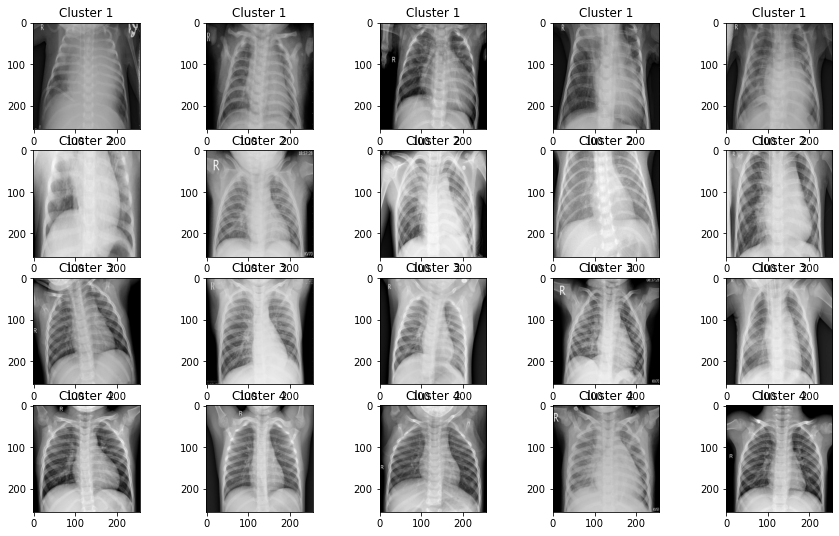

In [19]:
indices = get_indices(kmeans_rnk, 5)
view_images(indices)

## PCA:


In [20]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort, lambd

#Helper function to normalize matrix

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

#Helper function to plot skree plot of lambdas

def skree(lambd):
    plt.plot(np.arange(len(lambd)) + 1, lambd, 'ro-', linewidth = 2)
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    return

#Helper function to return variance explained and cumulataive sum of variance

def explained_variance(eigen_values):

  #explains how much of the data each component describes 
    var_exp = [(i/sum(eigen_values))*100 for i in eigen_values]
  
  #cumsum of var_exp for easier visualization
    cumsum_var = np.cumsum(var_exp)

    return var_exp, cumsum_var

#Helper function to viewcolumn vectors

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape(
        [256, 256], order='F'), cmap=plt.get_cmap('gray'))
    plt.show()

#Helper function to retrive indice where threshold variance is explained
#e.g. returns i = 4 if first 5 components explain threshold variance

def indexfinder(cumsum, threshold):
    for i in range(len(cumsum)):
        if cumsum[i] >= threshold:
            return i

In [21]:
x_raysPCA.shape

(65536, 5216)

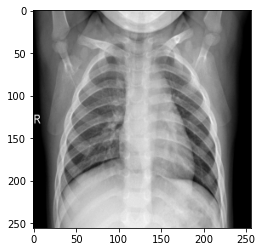

In [22]:
viewcolumn(x_raysPCA[:,0])

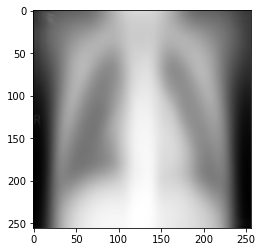

In [23]:
mean_xrays = np.mean(x_raysPCA, axis = 1)[:,None]
viewcolumn(mean_xrays)

In [24]:
A = (x_raysPCA - mean_xrays).real.astype(np.float32)
cov = np.divide(A.T@A, 5216)

In [25]:
eigvals, V = np.linalg.eig(cov)
Vsort, Dsort, lambd = eigsort(V, eigvals)

<ipython-input-20-b1edd943f5b5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:,i] = V[:,index[i]]


In [26]:
U = A @ Vsort
U = normc(U)

C:\Users\wilso\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


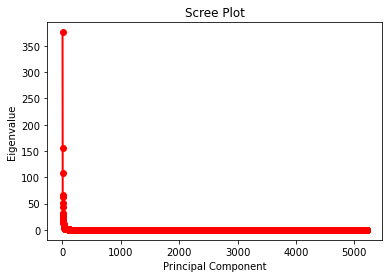

In [27]:
#Skree plot
#Elbow at near right angle, extreme drop off of variance explained by components 
#following elbow
skree(lambd)

In [28]:
exp, cumsum = explained_variance(eigvals)
cumsum

array([ 25.24716783+0.j,  35.67791558+0.j,  42.91349136+0.j, ...,
        99.99960329+0.j,  99.9997985 +0.j, 100.        +0.j])

In [29]:
indexfinder(cumsum, 96)

646

In [30]:
reduced_U = U[:625]
x_rays_temp = x_raysPCA[:,:625] - mean_xrays

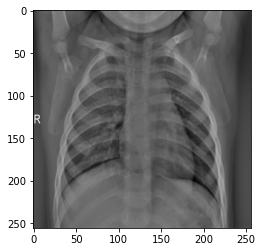

(65536, 625)

In [31]:
viewcolumn(x_rays_temp[:,0])
reduced_U.shape
x_rays_temp.shape

In [32]:
reduced_xrays = reduced_U.T @ x_rays_temp[:625]

In [33]:
zhat = U[:,:625] @ reduced_xrays[:625] + mean_xrays

In [34]:
#shape comparisons
reduced_xrays.shape, x_raysPCA.shape, zhat.shape

((5216, 625), (65536, 5216), (65536, 625))

## K-means with PCA:

We saw that K-means for 2 clusters was okay, but what about K-means with PCA for 2 clusters?

In [35]:
#KMeans on PCA reduced xrays, significantly faster
reduced_test, red_rnk = runKMeans(reduced_xrays, 2)

20.556464186822183
5.61829087609914
2.0295111376575137
1.035556220498751
1.252090954663903
2.0498563471636464
3.2455631554661997
5.577095709643405
10.906662743231058
21.294776784209535
31.75191893150389
28.483578320106215
21.800365251833316
18.386001578045928
3.3541519028708078
0.0
15
Total time: 2.3623249530792236


In [36]:
print(reduced_test.shape)

(2, 625)


<ipython-input-17-ff274d211ad2>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


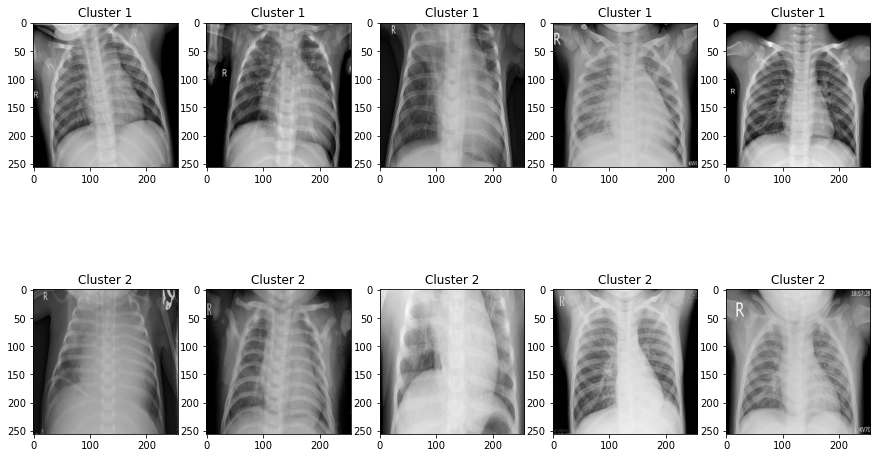

In [39]:
#cluster1, cluster2
indices = get_indices(red_rnk, 5)
view_images(indices)

## Comparing Runtime for K-means w/ and w/o PCA

In [42]:
#Time test
runKMeans(x_raysKMeans[:625], 10)

45693.21398363832
10277.655407043369
6618.127749462121
4934.888976637515
3079.647278564729
2304.183281618454
3400.1048832547217
2074.4846125068916
1827.5617939930778
1583.8624763826786
2154.2942012927642
1996.0016334622173
1226.5681622006243
900.1863519777584
630.5748191227358
561.2831566334074
0.0
16
Total time: 35.22720146179199


(array([[0.28704694, 0.29387998, 0.2969697 , ..., 0.10915033, 0.12109329,
         0.12655971],
        [0.17544351, 0.19262372, 0.19187675, ..., 0.02016807, 0.02194211,
         0.02577031],
        [0.20522876, 0.19006536, 0.20718954, ..., 0.09947712, 0.10444444,
         0.10666667],
        ...,
        [0.20089636, 0.22173669, 0.23086835, ..., 0.02134454, 0.01971989,
         0.01932773],
        [0.06700767, 0.08127309, 0.14606422, ..., 0.00920716, 0.01000284,
         0.01381074],
        [0.23784314, 0.22779412, 0.22      , ..., 0.1029902 , 0.10936275,
         0.12803922]]),
 array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]]))

In [43]:
runKMeans(reduced_xrays, 10)

170.27117243088276
103.73892220414496
117.6373227937341
96.75469521866049
80.95763040508436
92.70735475270341
86.96485421898001
102.17793985389349
110.12161229504684
87.20071400728186
59.83402052418505
47.719845511680376
30.834492782321842
17.527587359830207
46.1373716560204
55.194866628816705
41.90525323105332
48.916393859430094
50.995138403473995
88.2854290640399
38.785617800073354
10.08210009285119
10.992063096925673
8.103606598591528
4.975886968177428
8.87055211330687
8.16932133172987
5.954651687085718
4.93500841251306
3.143477800358109
2.3805572339499297
0.6812670072024163
0.35010731582286453
0.1134769421533302
0.08871217426694675
0.49774705214071147
0.5494429684261793
0.3090406384699609
0.037258183481184655
0.022816184980732436
0.021724485722582804
0.012577977677042844
0.017552827397471337
0.0062972215702458405
0.0
44
Total time: 21.29959225654602


(array([[ 0.96473094, -1.73935679,  1.02970958, ..., -0.23782274,
         -0.14057928,  0.9806727 ],
        [ 0.03882962, -0.11836583,  0.0396463 , ...,  0.01714643,
         -0.02941521,  0.04039646],
        [-0.14389099,  0.21371407, -0.15206839, ...,  0.05393638,
          0.01369238, -0.13956436],
        ...,
        [-1.03051859,  1.87088232, -1.10180914, ...,  0.2513347 ,
          0.14756884, -1.05065745],
        [ 0.34005598, -0.65645287,  0.35850442, ..., -0.09539834,
         -0.03659752,  0.34152952],
        [-0.37288121,  0.83282169, -0.39447392, ...,  0.07938162,
          0.06158829, -0.37975349]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]]))

So, not only was it able to cluster the images to 2 clusters, but it also (on average) runs faster.